In [1]:
# Imports, as always...
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

from scripts.dataset import get_projection_grid,icosahedral_grid_coordinates, random_rotation_matrix, rotate_grid, project_2d_on_sphere, s2_to_ico, random_icosahedral_rotation_matrix, rotate_signal
from scipy.spatial.transform import Rotation as R

from scripts.model import IcoCNN

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [2]:
def new_icosahedral_model():
    return IcoCNN(r=3, in_channels=1, out_channels=10, R_in=1, bias=True, smooth_vertices=True)

In [3]:
grid = get_projection_grid(b=24)
ico_grid = icosahedral_grid_coordinates(r=3)

# Analysis

In [7]:
def augment_and_project(x, grid, augment):
    # Augmentation.
    if augment == 's2':
        # Random continuous rotation.
        rotation_matrix = random_rotation_matrix()
        rotated_grid = rotate_grid(rotation_matrix, grid)
    elif augment == 'ico':
        # Random discrete rotation from the icosahedral symmetry group.
        icosahedral_group = R.create_group('I')
        icosahedral_rotations = icosahedral_group.as_matrix()
        rotation_matrix = random.choice(icosahedral_rotations)
        rotated_grid = rotate_grid(rotation_matrix, grid)
    else:
        rotated_grid = grid
        
    # Project.
    x = project_2d_on_sphere(x.numpy(), rotated_grid)
    return torch.from_numpy(
        x[:, None, :, :].astype(np.float32)
    )

In [8]:
# Define models.
models = {
    # Indexed by their training data's augmentation.
    'none' : new_icosahedral_model(),
    'ico'  : new_icosahedral_model(),
    's2'   : new_icosahedral_model()
}

# Load and move to device.
for augment, model in models.items():
    model.load_state_dict(torch.load(f'./models/online_augment/icosahedral_{augment}.pth'))
    model.to(device)

In [9]:
# Test data.
raw_test_dataset = MNIST(root='./data', train=False, download=True)
raw_test_data = raw_test_dataset.test_data.reshape(-1, 28, 28).to(torch.float64)
raw_test_labels = raw_test_dataset.test_labels

# Into dataset and loader objects.
test_dataset = TensorDataset(
    raw_test_data,
    raw_test_labels
)
test_loader = DataLoader(test_dataset, batch_size=64)

## Invariance

In [177]:
def invariance_test(model, loader, rotation_type='ico', verbose=False):
    running_loss = .0
    
    with torch.no_grad():
        for x, _ in (tqdm(loader, desc='Tseting.') if verbose else loader):
            # Augment and project.
            x_prime = augment_and_project(x, grid, augment=rotation_type)
            x = augment_and_project(x, grid, augment='none')
            
            # Onto the icosahedron.
            ico_x = torch.tensor([s2_to_ico(signal, ico_grid) for signal in x])
            ico_x_prime = torch.tensor([s2_to_ico(signal, ico_grid) for signal in x_prime])
            
            # Move to device.
            ico_x = ico_x.to(device)
            ico_x_prime = ico_x_prime.to(device)
            
            # Model.
            y = model(ico_x)
            y_prime = model(ico_x_prime)
            
            # Log softmax.
            y = F.log_softmax(y, dim=1)
            y_prime = F.log_softmax(y_prime, dim=1)
            
            # KL divergence to measure agreement.
            running_loss += F.kl_div(y, y_prime, log_target=True).item()
            
    return running_loss / len(loader.dataset)

In [178]:
inv_stats = {
    # Indexed by augmentation.
    augment : {'ico' : None, 's2' : None} for augment in models.keys()
}

for train_augment, model in tqdm(models.items()):
    for test_augment in inv_stats[train_augment].keys():
        inv_stats[train_augment][test_augment] = invariance_test(model, test_loader, rotation_type=test_augment, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
inv_stats = {
    'none': {'ico': 0.06040518444776535, 's2': 0.060014734053611754},
     'ico': {'ico': 0.0004992915648035705, 's2': 0.008268330442532897},
     's2': {'ico': 0.0006483823381364345, 's2': 0.0006396127253770829}
}

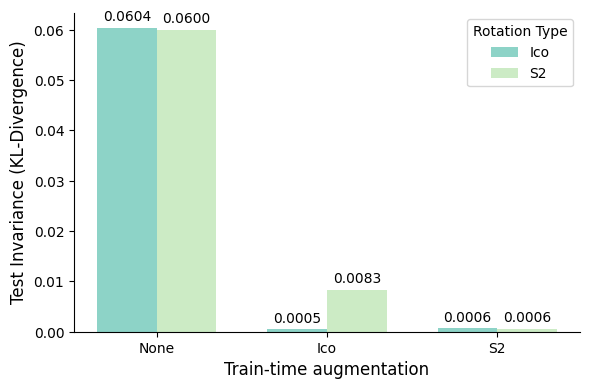

In [11]:
def do_invariance_plot(save_path):
    # --- Data Preparation ---
    # Categories for the x-axis (e.g., 'none', 'ico', 's2')
    x_categories = list(inv_stats.keys())
    # Assuming group labels ('ico', 's2') are consistent across categories
    group_labels = list(inv_stats[x_categories[0]].keys())

    # Reorganize scores: {group_label: [score_cat1, score_cat2, ...], ...}
    # This structure groups scores by the type of rotation ('ico' or 's2')
    scores_by_group = {group: [] for group in group_labels}
    for category in x_categories:
        for group in group_labels:
            scores_by_group[group].append(inv_stats[category][group])

    # --- Plotting Setup ---
    n_x_categories = len(x_categories)
    n_groups = len(group_labels)

    # Calculate bar positions to achieve grouping (following example style)
    x_indices = np.arange(n_x_categories) # Base positions for the groups [0, 1, 2]
    bar_width = 0.35  # Width of a single bar
    # Total width occupied by the bars for one x_category
    total_group_width = bar_width * n_groups
    # Calculate the offset needed to center the group of bars over the x-tick
    offset_for_centering = (total_group_width - bar_width) / 2

    fig, ax = plt.subplots(figsize=(6, 4)) # Adjust figure size if needed

    cmap_name = 'Set3'
    colormap = cm.get_cmap(cmap_name)
    colors = [colormap(i) for i in np.linspace(0, 0.85, n_groups)]
    ax.set_prop_cycle(color=colors)

    # --- Create Bars ---
    # Loop through each group ('ico', 's2') and plot its bars across all x_categories
    for i, group in enumerate(group_labels):
        # Calculate the specific x-position for the bars of the current group
        # Start from the center (x_indices), shift left to center the whole group,
        # then shift right based on the current group's index (i).
        bar_positions = x_indices - offset_for_centering + i * bar_width

        # Get the scores for this specific group (e.g., all 'ico' scores)
        scores = scores_by_group[group]

        # Plot the bars for the current group
        rects = ax.bar(bar_positions, scores, bar_width,
                       label=group.capitalize()) # Use group name for legend

        # Add score labels above each bar
        ax.bar_label(rects, padding=3, fmt='%.4f') # Format for score values

    # --- Customize Plot ---
    ax.set_xlabel('Train-time augmentation', fontsize=12)
    ax.set_ylabel('Test Invariance (KL-Divergence)', fontsize=12)
    # ax.set_title('Model Invariance Score by Training Dataset and Rotation Type') # Optional title
    ax.set_xticks(x_indices) # Set the positions of the x-axis ticks to the group centers
    ax.set_xticklabels([x.capitalize() for x in x_categories]) # Set the labels for the x-axis ticks
    ax.legend(title='Rotation Type') # Add a legend to identify bar colors

    # Optional: Remove plot borders like in the example
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout to prevent labels overlapping
    plt.tight_layout()

    # --- Save Plot (Optional) ---
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight') # Use bbox_inches for tight saving

    # --- Show Plot ---
    plt.show()
    
do_invariance_plot('./figures/invariance_by_augment.pdf')

## Equivariance

In [27]:
def equivariance_test(model, loader, rotation_type='ico', verbose=False):
    running_loss = .0
    
    with torch.no_grad():
        for x, _ in (tqdm(loader, desc='Testing.') if verbose else loader):
            # Augmentation.
            if rotation_type == 's2':
                # Random continuous rotation.
                rotation_matrix = random_rotation_matrix()
                
            else:
                # Random discrete rotation from the icosahedral symmetry group.
                icosahedral_group = R.create_group('I')
                icosahedral_rotations = icosahedral_group.as_matrix()
                rotation_matrix = random.choice(icosahedral_rotations)
                #rotation_matrix = random_icosahedral_rotation_matrix()
                
            #rotated_grid = rotate_grid(rotation_matrix, grid)
                
            #x_prime = project_2d_on_sphere(x.numpy(), rotated_grid)
            #x_prime = torch.from_numpy(
            #    x_prime[:, None, :, :].astype(np.float32)
            #)
            
            x = project_2d_on_sphere(x.numpy(), grid)
            x = torch.from_numpy(
                x[:, None, :, :].astype(np.float32)
            )
            
            # Onto the icosahedron.
            ico_x = torch.tensor([s2_to_ico(signal, ico_grid) for signal in x])
            ico_x_prime = torch.tensor([rotate_signal(ico_signal, rotation_matrix).numpy() for ico_signal in ico_x])
            
            # Move to device.
            ico_x = ico_x.to(device)
            ico_x_prime = ico_x_prime.to(device)
            
            # Model.
            y = F.relu(model.conv1(ico_x))
            y = F.relu(model.conv2(y))
            
            y_prime = F.relu(model.conv1(ico_x_prime))
            y_prime = F.relu(model.conv2(y_prime))
            
            # Rotating output for y.
            y = torch.tensor([rotate_signal(ico_signal, rotation_matrix).cpu().numpy() for ico_signal in y])
            y = y.to(device)
            
            # Measure similarity.
            #running_loss += torch.mean((y - y_prime) ** 2).item()
            running_loss += F.cosine_similarity(
                y.view(y.size(0), y.size(1), -1),
                y_prime.view(y.size(0), y.size(1), -1),
            dim=-1).mean().item()
            
    return running_loss / len(loader.dataset)

In [30]:
equ_stats = {
    # Indexed by augmentation.
    augment : {'ico' : None, 's2' : None} for augment in models.keys() if augment != 'none'
}

for train_augment, model in tqdm(models.items()):
    if train_augment == 'none': continue
    for test_augment in equ_stats[train_augment].keys():
        equ_stats[train_augment][test_augment] = equivariance_test(model, test_loader, rotation_type=test_augment, verbose=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

In [126]:
equ_stats

{'ico': {'ico': 0.0017803172752261162, 's2': 0.0018940687742084264},
 's2': {'ico': 0.0026208006247878074, 's2': 0.0027335219338536264}}

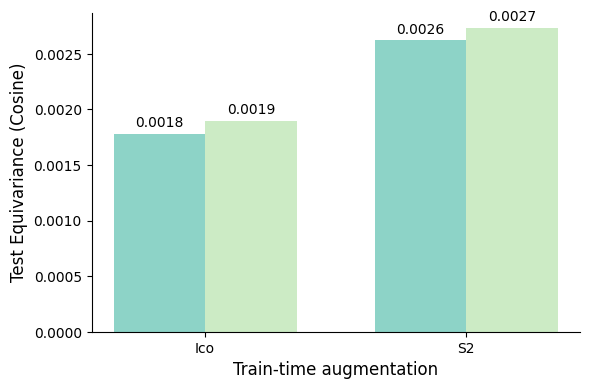

In [129]:
def do_equivariance_plot(save_path):
    # --- Data Preparation ---
    # Categories for the x-axis (e.g., 'none', 'ico', 's2')
    x_categories = list(equ_stats.keys())
    # Assuming group labels ('ico', 's2') are consistent across categories
    group_labels = list(equ_stats[x_categories[0]].keys())

    # Reorganize scores: {group_label: [score_cat1, score_cat2, ...], ...}
    # This structure groups scores by the type of rotation ('ico' or 's2')
    scores_by_group = {group: [] for group in group_labels}
    for category in x_categories:
        for group in group_labels:
            scores_by_group[group].append(equ_stats[category][group])

    # --- Plotting Setup ---
    n_x_categories = len(x_categories)
    n_groups = len(group_labels)

    # Calculate bar positions to achieve grouping (following example style)
    x_indices = np.arange(n_x_categories) # Base positions for the groups [0, 1, 2]
    bar_width = 0.35  # Width of a single bar
    # Total width occupied by the bars for one x_category
    total_group_width = bar_width * n_groups
    # Calculate the offset needed to center the group of bars over the x-tick
    offset_for_centering = (total_group_width - bar_width) / 2

    fig, ax = plt.subplots(figsize=(6, 4)) # Adjust figure size if needed

    cmap_name = 'Set3'
    colormap = cm.get_cmap(cmap_name)
    colors = [colormap(i) for i in np.linspace(0, 0.85, n_groups)]
    ax.set_prop_cycle(color=colors)

    # --- Create Bars ---
    # Loop through each group ('ico', 's2') and plot its bars across all x_categories
    for i, group in enumerate(group_labels):
        # Calculate the specific x-position for the bars of the current group
        # Start from the center (x_indices), shift left to center the whole group,
        # then shift right based on the current group's index (i).
        bar_positions = x_indices - offset_for_centering + i * bar_width

        # Get the scores for this specific group (e.g., all 'ico' scores)
        scores = scores_by_group[group]

        # Plot the bars for the current group
        rects = ax.bar(bar_positions, scores, bar_width,
                       label=group.capitalize()) # Use group name for legend

        # Add score labels above each bar
        ax.bar_label(rects, padding=3, fmt='%.4f') # Format for score values

    # --- Customize Plot ---
    ax.set_xlabel('Train-time augmentation', fontsize=12)
    ax.set_ylabel('Test Equivariance (Cosine)', fontsize=12)
    # ax.set_title('Model Invariance Score by Training Dataset and Rotation Type') # Optional title
    ax.set_xticks(x_indices) # Set the positions of the x-axis ticks to the group centers
    ax.set_xticklabels([x.capitalize() for x in x_categories]) # Set the labels for the x-axis ticks
    #ax.legend(title='Rotation Type') # Add a legend to identify bar colors

    # Optional: Remove plot borders like in the example
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout to prevent labels overlapping
    plt.tight_layout()

    # --- Save Plot (Optional) ---
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight') # Use bbox_inches for tight saving

    # --- Show Plot ---
    plt.show()
    
do_equivariance_plot('./figures/equivariance_by_augment.pdf')

In [71]:
def chart_equivariant_errors(model, loader, rotation_type='ico', verbose=False):
    errors = []
    
    with torch.no_grad():
        for x, _ in (tqdm(loader, desc='Testing.') if verbose else loader):
            # Onto the sphere.
            x = project_2d_on_sphere(x.numpy(), grid)
            x = torch.from_numpy(
                x[:, None, :, :].astype(np.float32)
            )
            
            # Onto the icosahedron.
            ico_x = torch.tensor([s2_to_ico(signal, ico_grid) for signal in x])
            
            # Rotation.
            if rotation_type == 's2':
                rotation_matrix = random_rotation_matrix()
            else:
                rotation_matrix = random_icosahedral_rotation_matrix()
                
            ico_x_prime = ico_x.clone()
            ico_x_prime = rotate_signal(ico_x_prime, rotation_matrix, ico_grid)
            
            # Move to device.
            ico_x = ico_x.to(device)
            ico_x_prime = ico_x_prime.to(device)
            
            # Model.
            y = F.relu(model.conv1(ico_x))
            y = F.relu(model.conv2(y))
            
            y_prime = F.relu(model.conv1(ico_x_prime))
            y_prime = F.relu(model.conv2(y_prime))
            
            # Rotating output for y.
            y = rotate_signal(y, rotation_matrix, ico_grid)
            y = y.to(device)
            
            # Squeeze out the singleton scalar field.
            y = y.squeeze(2)
            y_prime = y_prime.squeeze(2)
            
            # Similarity.
            error = ((y - y_prime) ** 2).mean(dim=(0, 1))
            errors.append(error.cpu().numpy())
            
    return np.array(errors)

In [72]:
errors = chart_equivariant_errors(models['none'], test_loader, 'ico', True)

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

In [78]:
errors = errors.mean(axis=0)

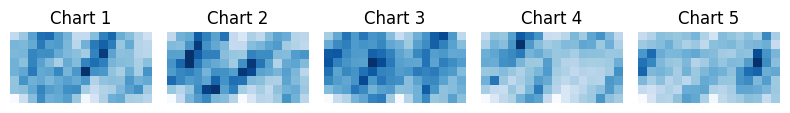

In [87]:
cmap = cm.get_cmap('Blues')

fig, axes = plt.subplots(1, 5, figsize=(8, 3))
for i in range(5):
    ax = axes[i]
    im = ax.imshow(errors[i], origin='lower', cmap=cmap)
    ax.set_title(f'Chart {i+1}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [94]:
errors_by_augment = {}

for train_augment in ['ico', 's2']:
    for test_augment in ['ico', 's2']:
        errors_by_augment[(train_augment, test_augment)] = chart_equivariant_errors(models[train_augment], test_loader, test_augment, True).mean(axis=0)

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

Testing.:   0%|          | 0/157 [00:00<?, ?it/s]

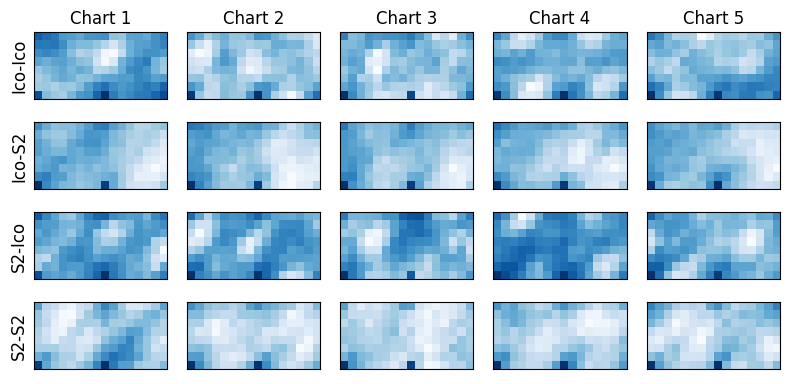

In [124]:
cmap = cm.get_cmap('Blues_r')

fig, axes = plt.subplots(4, 5, figsize=(8, 4))
for j in range(4):
    for i in range(5):
        ax = axes[j][i]
        im = ax.imshow(errors_by_augment[list(errors_by_augment.keys())[j]][i], origin='lower', cmap=cmap)
        if j == 0:
            ax.set_title(f'Chart {i+1}')
        if i == 0:
            label = '-'.join((x.capitalize() for x in list(errors_by_augment.keys())[j]))
            ax.set_ylabel(label, fontsize=12)
        #ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
    
plt.tight_layout()
#plt.savefig('./figures/chart_equivariance_heatmaps.pdf', bbox_inches='tight')
plt.show()

In [119]:
equ_stats = {
    'ico': {
        'ico' : errors_by_augment[('ico', 'ico')].mean(),
        's2'  : errors_by_augment[('ico', 's2')].mean()
    },
    's2': {
        'ico' : errors_by_augment[('s2', 'ico')].mean(),
        's2'  : errors_by_augment[('s2', 's2')].mean()
    }
}

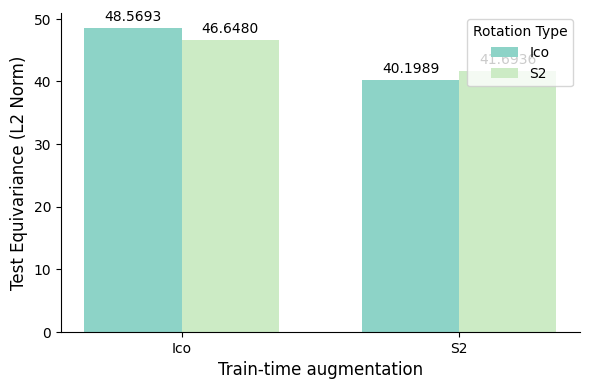

In [121]:
do_equivariance_plot(None)